In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


# Blind source separation using NMF

Toy example using two sinusoidal signals


In [3]:
print(__doc__)

import os as os
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy.signal import stft, istft, spectrogram, chirp, butter, lfilter, freqz
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from numpy import linalg


Automatically created module for IPython interactive environment


In [4]:
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams.update({'font.size': 26})

In [5]:
figPath = './figs-01-31/'
fs = int(10e6)
f1 = 1e6
secondsOfData = 0.01
numberOfSamples = int(secondsOfData*fs)
nfft = 256
nperseg = 256
beta_loss = 'kullback-leibler'
save_fig = False
exp_name = '1sin_noise'

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
def db2pow(y):
    return 10.**(y/10.)

In [8]:
def plotSpectrogram(f, t, Sxx, vmin=None, vmax=None, save_fig=False, fig_path=None, figName=None):
    specdB = 10*np.log10(np.abs(Sxx))    
    cmap = plt.get_cmap('jet')
    
    if vmin==None and vmax==None:
        vmin = np.min(specdB)
        vmax = np.max(specdB)       
        
    plt.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel('Frequency [MHz]')
    plt.xlabel('Time [ms]')
    plt.colorbar().ax.set_ylabel('[dB]')
    plt.tight_layout()
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        figName = ''.join([figName, '.eps'])
        plt.savefig(os.path.join(fig_path,figName), dpi=100, format='eps')
    plt.show()

In [9]:
def saveFig(fig, fig_path, fig_name, save_fig=False):
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig_name = ''.join([fig_name, '.eps'])
        fig.savefig(os.path.join(fig_path, fig_name), dpi=100, format='eps')

# Generate and mix signals

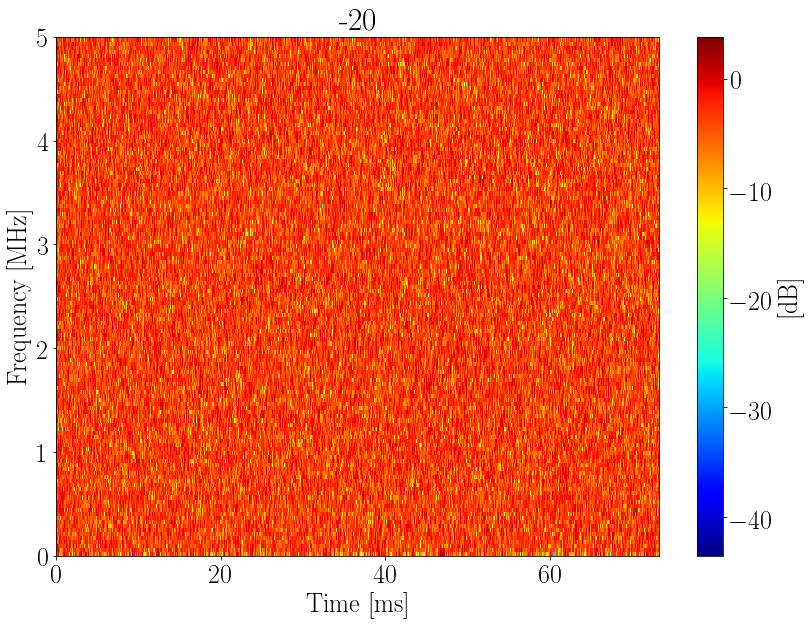

Epoch 10 reached after 0.113 seconds, error: 314.176726
Epoch 20 reached after 0.210 seconds, error: 314.176726


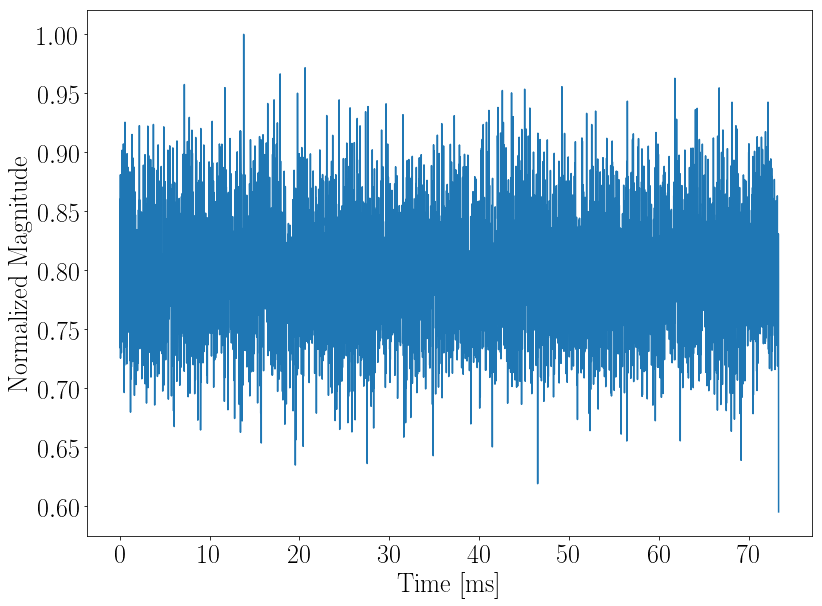

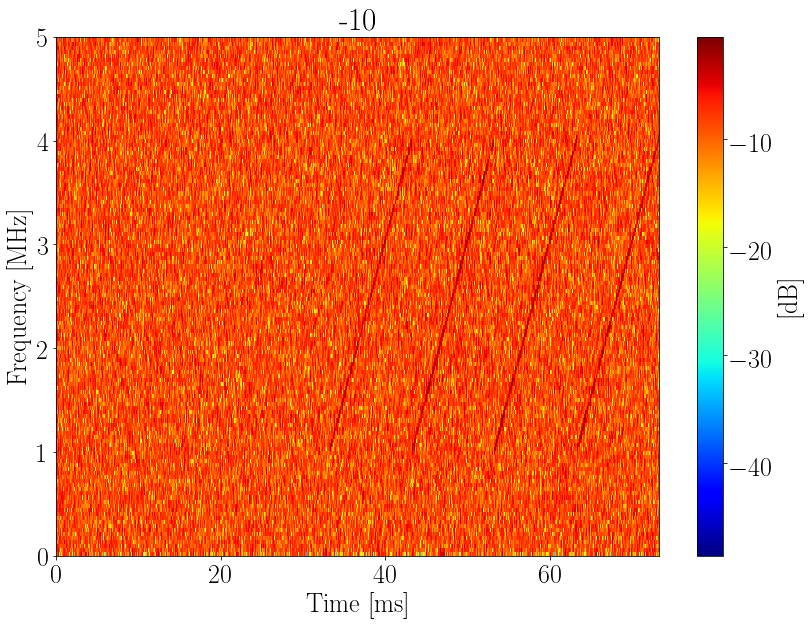

Epoch 10 reached after 0.122 seconds, error: 182.364348
Epoch 20 reached after 0.266 seconds, error: 182.364348


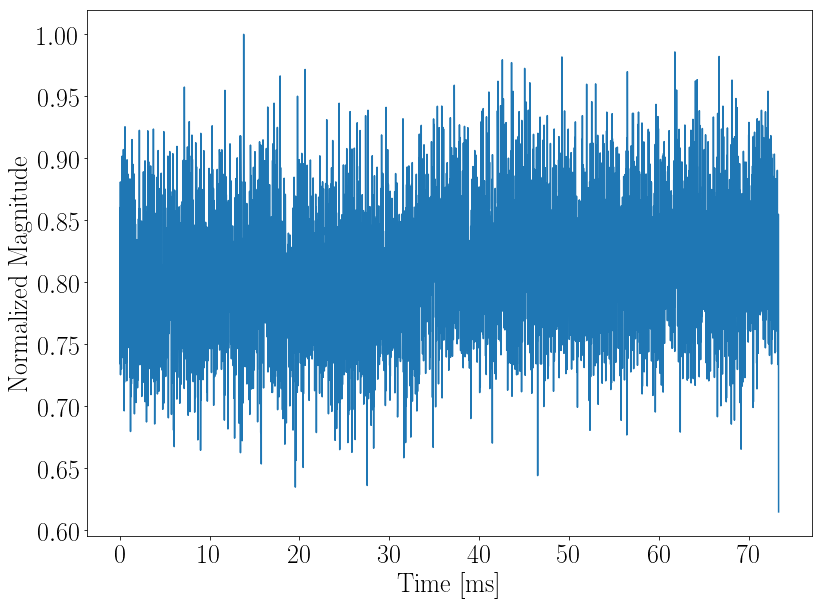

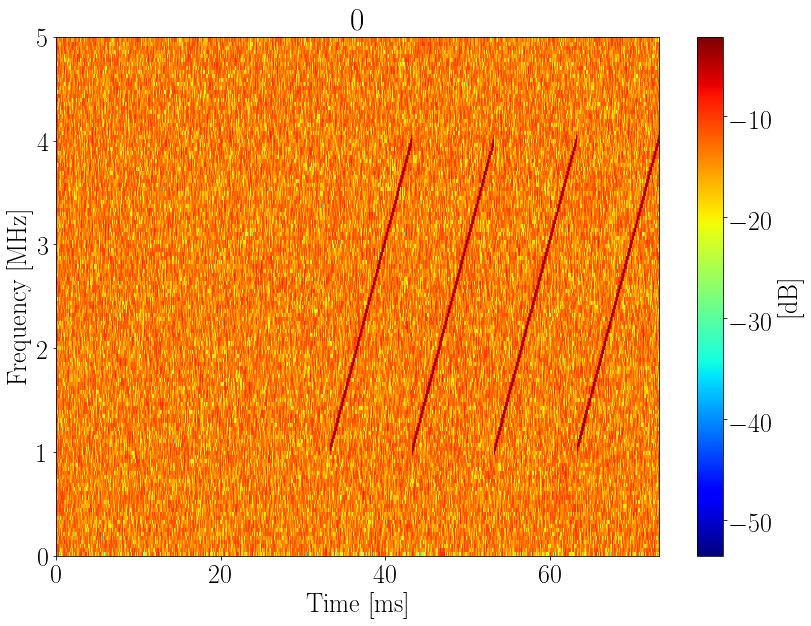

Epoch 10 reached after 0.127 seconds, error: 128.350308
Epoch 20 reached after 0.224 seconds, error: 128.350308


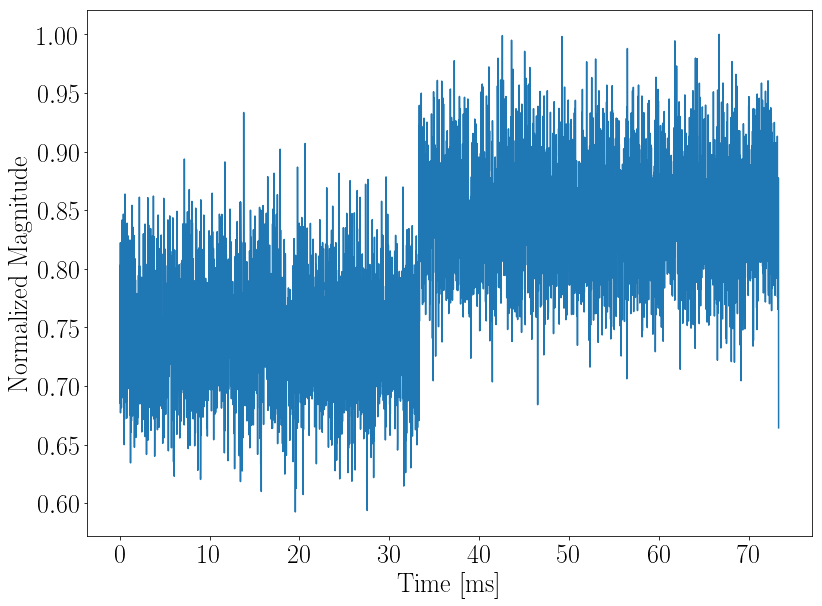

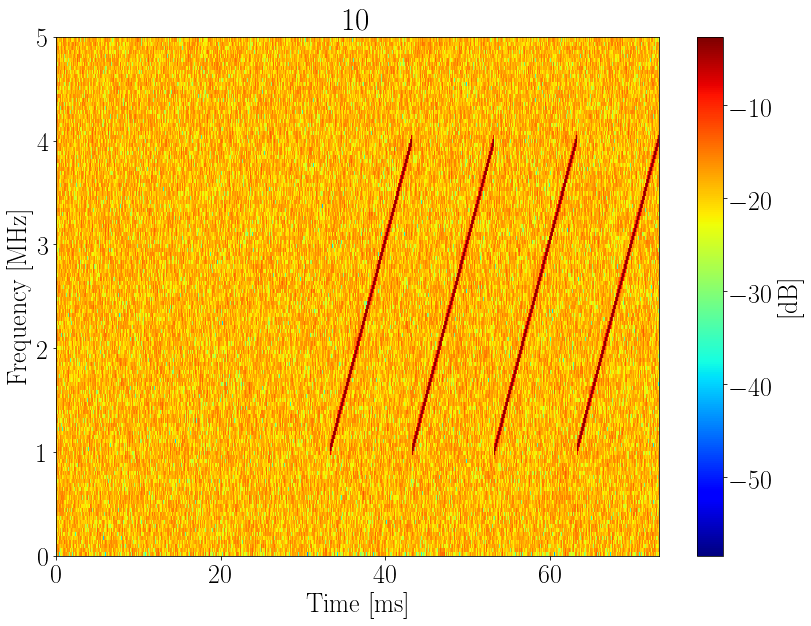

Epoch 10 reached after 0.113 seconds, error: 122.489191
Epoch 20 reached after 0.209 seconds, error: 122.489191


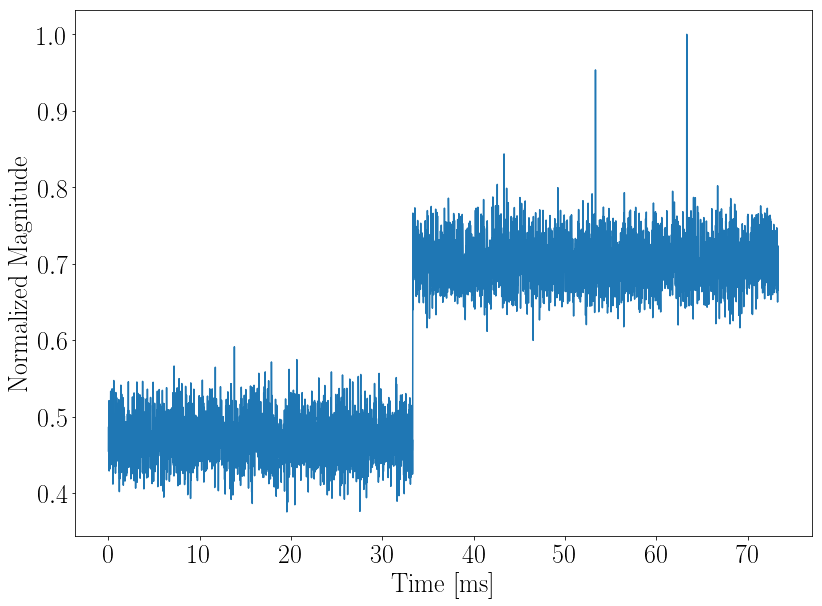

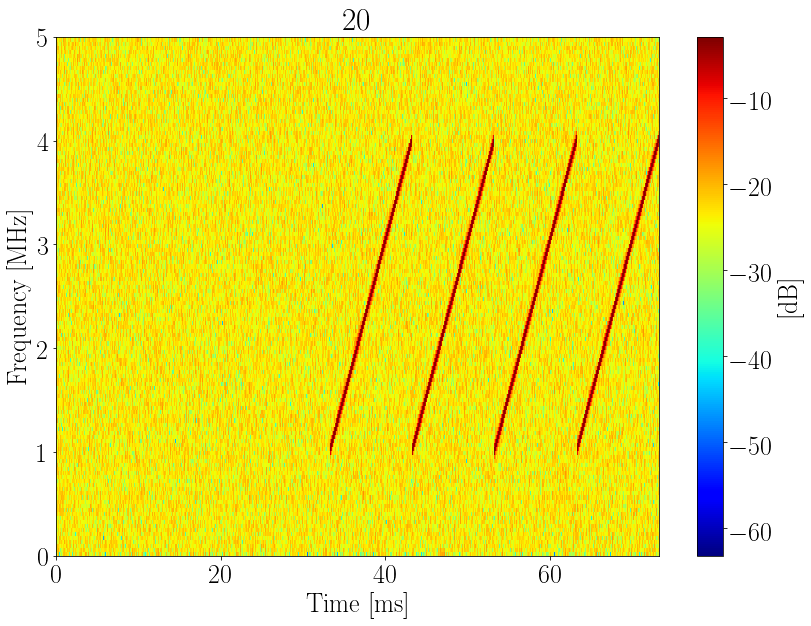

Epoch 10 reached after 0.112 seconds, error: 130.677469
Epoch 20 reached after 0.207 seconds, error: 130.677469


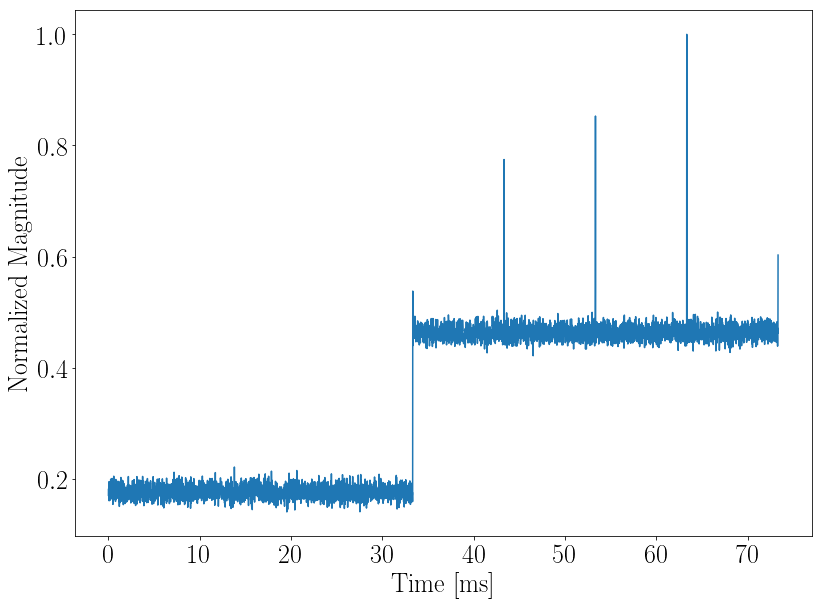

In [19]:
JNRVector = [-20, -10, 0, 10, 20]
JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]


t = np.linspace(0, secondsOfData, numberOfSamples)
signal1 = chirp(t, f1, secondsOfData, f1*4)
signal1 = np.tile(signal1, 4)
pow1 = (np.linalg.norm(signal1)**2)/len(signal1)
signal1 = np.concatenate((np.zeros(np.round(signal1.shape[0]/1.2).astype(int)), signal1))
noise = np.random.randn(len(signal1))
powNoise = (np.linalg.norm(noise)**2)/len(noise)


for j, i in enumerate(JNR):
    powAux = pow1/i
    noise2 = noise*np.sqrt(powAux/powNoise)
    data = signal1+noise2

    f, t, Zxx = stft(data, fs=fs, nperseg=nperseg, nfft=nfft, boundary=None)
    inputNMF = np.abs(Zxx)
    inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)

    specdB = 10*np.log10(inputNMF)    
    cmap = plt.get_cmap('jet')
    vmin = np.min(specdB)
    vmax = np.max(specdB)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    v = ax.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_ylabel('Frequency [MHz]')
    ax.set_xlabel('Time [ms]')
    fig.colorbar(v).ax.set_ylabel('[dB]')
    plt.tight_layout()
    saveFig(fig, figPath, ''.join(['spec_input_', exp_name]), save_fig=save_fig)
    plt.title(str(JNRVector[j]))
    plt.show()

    model = NMF(init='nndsvda', max_iter=10000, verbose=2, random_state=1, tol=1e-16, 
                  beta_loss=beta_loss, n_components=1, solver='mu')
    W = model.fit_transform(inputNMF)
    H = model.components_

    for i in range(H.shape[0]):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(t*1e3, H[i,:]/np.max(H[i,:]))
        ax.set_xlabel('Time [ms]')
        ax.set_ylabel('Normalized Magnitude')
        fig.tight_layout()
        saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(i)]), save_fig=save_fig)
        plt.show()

# Saving log file

In [31]:
import json

In [32]:
log_path = './log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
params = model.get_params()
params['nfft'] = nfft
params['nperseg'] = nperseg
params = json.dumps(params)
if save_fig:
    with open(''.join([log_path, exp_name, beta_loss, '.p']), 'w') as file:
         file.write(params)